In [ ]:
!pip install -q transformers datasets
!pip install -q pytorch-lightning wandb
!pip install -q sentencepiece

In [ ]:
import pandas as pd
import numpy as np
import json
from PIL import Image
from datasets import Dataset, DatasetDict
from google.colab import drive
drive.mount('/content/drive')

def get_data_from_path(data_path):
    data_list = []
    with open(data_path + '/metadata.jsonl', 'r') as file:
        for line in file:
            data = json.loads(line)
            data['image'] = Image.open(data_path + '/' + data['file_name'])
            del data['file_name']
            data_list.append(data)
    return data_list
def load_data(data_path):
    train_data = get_data_from_path(data_path + '/train')
    test_data = get_data_from_path(data_path + '/test')
    validation_data = get_data_from_path(data_path + '/validation')
    dataset = DatasetDict({
        'train': train_data,
        'validation': validation_data,
        'test': test_data
    })
    print(dataset)
    return dataset
dataset = load_data('/content/drive/My Drive/donut/donut_data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DatasetDict({
    train: [{'ground_truth': '{"gt_parse": {"DCNM": "Ontario Driver\'s Licence CANADA", "SURN": "RAKHIMOV ALI", "AD": "LPH202-18 SPRING GARDEN AVE NORTH YORK, ON, M2N 7M2", "DOB": "", "DOE": "2023/01/16", "LNUM": "RO221-02305-80105", "C": "G1", "REFN": "DZ8451503", "CON": "", "DOI": "2018/01/17", "SEX": "M", "H": "187 cm", "W": "", "EYEC": "", "HC": ""}}', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1015x637 at 0x7C694A930490>}, {'ground_truth': '{"gt_parse": {"DCNM": "Saskatchewan driver\'s licence", "SURN": "BOURQUE Cole Francis", "AD": "NE32 33 32 W1 RM of Livingston SK", "DOB": "1997 NOV 21", "DOE": "2022 NOV 30", "LNUM": "37605862", "C": "5", "REFN": "028816107319971121 M", "CON": "", "DOI": "2017 DEC 22", "SEX": "M", "H": "163 cm", "W": "", "EYEC": "BROWN", "HC": ""}}', 'image': <PIL.JpegImagePlugin.JpegImageFile image 

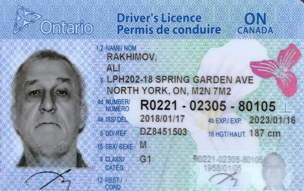

In [ ]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [ ]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'DCNM': "Ontario Driver's Licence CANADA",
 'SURN': 'RAKHIMOV ALI',
 'AD': 'LPH202-18 SPRING GARDEN AVE NORTH YORK, ON, M2N 7M2',
 'DOB': '',
 'DOE': '2023/01/16',
 'LNUM': 'RO221-02305-80105',
 'C': 'G1',
 'REFN': 'DZ8451503',
 'CON': '',
 'DOI': '2018/01/17',
 'SEX': 'M',
 'H': '187 cm',
 'W': '',
 'EYEC': '',
 'HC': ''}

In [ ]:
from transformers import VisionEncoderDecoderConfig
from transformers import DonutProcessor, VisionEncoderDecoderModel

image_size = [1280, 960]
max_length = 768

config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
config.decoder.max_length = max_length


processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.

    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into pixel_values (vectorized image) and labels (input_ids of the tokenized string).

    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = dataset_name_or_path#load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            # if "gt_parse" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
            #     assert isinstance(ground_truth["gt_parse"], list)
            #     gt_jsons = ground_truth["gt_parse"]
            # else:
            #     assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
            #     gt_jsons = [ground_truth["gt_parse"]]
            gt_jsons = [ground_truth["gt_parse"]]


            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

In [ ]:
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False
print(dataset)
train_dataset = DonutDataset(dataset['train'],#"naver-clova-ix/cord-v2",
                             max_length=max_length,
                             split="train", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset(dataset['validation'],#"naver-clova-ix/cord-v2",
                           max_length=max_length,
                             split="validation", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

DatasetDict({
    train: [{'ground_truth': '{"gt_parse": {"DCNM": "Ontario Driver\'s Licence CANADA", "SURN": "RAKHIMOV ALI", "AD": "LPH202-18 SPRING GARDEN AVE NORTH YORK, ON, M2N 7M2", "DOB": "", "DOE": "2023/01/16", "LNUM": "RO221-02305-80105", "C": "G1", "REFN": "DZ8451503", "CON": "", "DOI": "2018/01/17", "SEX": "M", "H": "187 cm", "W": "", "EYEC": "", "HC": ""}}', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1015x637 at 0x7C694A930490>}, {'ground_truth': '{"gt_parse": {"DCNM": "Saskatchewan driver\'s licence", "SURN": "BOURQUE Cole Francis", "AD": "NE32 33 32 W1 RM of Livingston SK", "DOB": "1997 NOV 21", "DOE": "2022 NOV 30", "LNUM": "37605862", "C": "5", "REFN": "028816107319971121 M", "CON": "", "DOI": "2017 DEC 22", "SEX": "M", "H": "163 cm", "W": "", "EYEC": "BROWN", "HC": ""}}', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1015x649 at 0x7C694A9313F0>}, {'ground_truth': '{"gt_parse": {"DCNM": "Manitoda DRIVER\'S LICENCE CAN", "SURN": "DA

In [ ]:
len(added_tokens)

32

In [ ]:
print(added_tokens)

['<s_DCNM>', '</s_DCNM>', '<s_SURN>', '</s_SURN>', '<s_AD>', '</s_AD>', '<s_DOB>', '</s_DOB>', '<s_DOE>', '</s_DOE>', '<s_LNUM>', '</s_LNUM>', '<s_C>', '</s_C>', '<s_REFN>', '</s_REFN>', '<s_CON>', '</s_CON>', '<s_DOI>', '</s_DOI>', '<s_SEX>', '</s_SEX>', '<s_H>', '</s_H>', '<s_W>', '</s_W>', '<s_EYEC>', '</s_EYEC>', '<s_HC>', '</s_HC>', '<s_cord-v2>', '<s_cord-v2>']


In [ ]:
# the vocab size attribute stays constants (might be a bit unintuitive - but doesn't include special tokens)
print("Original number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens after adding special tokens:", len(processor.tokenizer))

Original number of tokens: 57522
Number of tokens after adding special tokens: 57556


In [ ]:
processor.decode([57560])

''

In [ ]:
pixel_values, labels, target_sequence = train_dataset[0]

In [ ]:
print(pixel_values.shape)


torch.Size([3, 1280, 960])


In [ ]:
# let's print the labels (the first 30 token ID's)
for id in labels.tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_DCNM>
On
tario
Drive
r
'
s
Lice
nce
CAN
ADA
</s_DCNM>
<s_SURN>
R
AK
HIM
OV
A
LI
</s_SURN>
<s_AD>
L
PH
20
2
-18
SPR
ING

GAR


In [ ]:
# let's check the corresponding target sequence, as a string
print(target_sequence)

<s_DCNM>Ontario Driver's Licence CANADA</s_DCNM><s_SURN>RAKHIMOV ALI</s_SURN><s_AD>LPH202-18 SPRING GARDEN AVE NORTH YORK, ON, M2N 7M2</s_AD><s_DOB></s_DOB><s_DOE>2023/01/16</s_DOE><s_LNUM>RO221-02305-80105</s_LNUM><s_C>G1</s_C><s_REFN>DZ8451503</s_REFN><s_CON></s_CON><s_DOI>2018/01/17</s_DOI><s_SEX>M</s_SEX><s_H>187 cm</s_H><s_W></s_W><s_EYEC></s_EYEC><s_HC></s_HC></s>


In [ ]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_cord-v2>'])[0]

In [ ]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [ ]:
for id in labels.squeeze().tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_DCNM>
Sa
skat
che
wan
driver
'
s
lice
nce
</s_DCNM>
<s_SURN>
B
OUR
Q
UE
Cole
Francis
</s_SURN>
<s_AD>
NE
32
33
32
W
<unk>
RM
of
Living
ston


In [ ]:
print(len(train_dataset))
print(len(val_dataset))

10
10


In [ ]:
print(len(val_dataloader))
# let's check the first validation batch
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

10
torch.Size([1, 3, 1280, 960])


In [ ]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch

        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)

        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)

        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [ ]:
config = {"max_epochs":30,
          "val_check_interval":0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

In [ ]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credent

In [ ]:
!git config --global credential.helper store


In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping
from google.colab import drive
drive.mount('/content/drive')

wandb_logger = WandbLogger(project="Donut", name="demo-run-cord")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        # pl_module.model.push_to_hub("nielsr/donut-demo",
                                    # commit_message=f"Training in progress, epoch {trainer.current_epoch}")
        pl_module.model.save_pretrained("/content/drive/My Drive/donut/donut_weight/donut_model")
    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        # pl_module.processor.push_to_hub("nielsr/donut-demo",
        #                             commit_message=f"Training done")
        # pl_module.model.push_to_hub("nielsr/donut-demo",
        #                             commit_message=f"Training done")
        pl_module.processor.save_pretrained("/content/drive/My Drive/donut/donut_weight/donut_processor")
        pl_module.model.save_pretrained("/content/drive/My Drive/donut/donut_weight/donut_model")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
)

trainer.fit(model_module)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


MisconfigurationException: ignored

## Evaluate

In [ ]:
!pip install -q donut-python

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
from google.colab import drive
import gdown
import shutil
import zipfile
drive.mount('/content/drive')

processor = DonutProcessor.from_pretrained("/content/drive/My Drive/donut/donut_weight/donut_processor")
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/My Drive/donut/donut_weight/donut_model")

In [ ]:
import re
import json
import glob
import torch
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

# filename = '/content/drive/My Drive/donut_Images_without_Data/00658/00025.tif'
filename = '/content/drive/My Drive/donut_Images_with_Data/103/0003_103_0017.tif'

image = Image.open(filename)
pixel_values = processor(image.convert("RGB"), return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)
# prepare decoder inputs
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
decoder_input_ids = decoder_input_ids.to(device)

# autoregressively generate sequence
outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

# turn into JSON
seq = processor.batch_decode(outputs.sequences)[0]
seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
seq = processor.token2json(seq)
print(seq)

In [ ]:
import re
import json
import glob
import torch
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

# dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")
for idx, filename in enumerate(glob.glob('/content/drive/My Drive/donut_Images_without_Data/00658/*.tif')):
# for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    # pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    image = Image.open(filename)
    pixel_values = processor(image.convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)

    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    ground_truth = ground_truth["gt_parse"]
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

MessageError: ignored

In [ ]:
print("Mean accuracy:", np.mean(accs))
